# 1. Libraries

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib
# !pip install keras

In [ ]:
import os
import zipfile
import shutil
import numpy as np
import cv2
import imghdr
import tensorflow as tf
import numpy as np
import plotly
import plotly.graph_objects as go

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from keras.models import load_model
# from keras.metrics import Precision, Recall
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten
from matplotlib import pyplot as plt


# GPU CHeck for Colab

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **COLAB kaggle data file SETUP**

In [ ]:
# Step 1: Set up Kaggle API credentials
kaggle_credentials_path = "/content/kaggle.json"
if os.path.exists(kaggle_credentials_path):
    kaggle_directory = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_directory, exist_ok=True)
    kaggle_config_path = os.path.join(kaggle_directory, "kaggle.json")
    shutil.copy(kaggle_credentials_path, kaggle_config_path)
    os.chmod(kaggle_config_path, 0o600)
    # Step 2: Download dataset
    dataset_name = "krishnapaanchajanya/american-sign-language-asl"
    download_command = f"kaggle datasets download -d {dataset_name}"
    os.system(download_command)
    # Step 3: Unzip dataset and remove ZIP files
    zip_files = [file for file in os.listdir() if file.endswith(".zip")]
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall()
        os.remove(zip_file)
    print("Dataset download and setup completed.")
else:
    print("Kaggle API credentials (kaggle.json) not found.")



Dataset download and setup completed.


# 2. Remove dodgy images

In [ ]:
dataRAW_dir = '/content/American Sign Language (ASL)/data'
dataAT_dir = '/content/American Sign Language (ASL)/dataAT'
dataCE_dir = '/content/American Sign Language (ASL)/dataCE'
dir_list =[dataRAW_dir, dataAT_dir, dataCE_dir]

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for dir in dir_list:
  for image_class in os.listdir(dir):
      for image in os.listdir(os.path.join(dir, image_class)):
          image_path = os.path.join(dir, image_class, image)
          try:
              img = cv2.imread(image_path)
              tip = imghdr.what(image_path)
              if tip not in image_exts:
                  print('Image not in ext list {}'.format(image_path))
                  os.remove(image_path)
          except Exception as e:
              print('Issue with image {}'.format(image_path))

# 3. Load Data

In [ ]:
dataRAW = tf.keras.utils.image_dataset_from_directory(dataRAW_dir)
dataAT = tf.keras.utils.image_dataset_from_directory(dataAT_dir)
dataCE = tf.keras.utils.image_dataset_from_directory(dataCE_dir)

Found 8100 files belonging to 27 classes.
Found 8100 files belonging to 27 classes.
Found 8100 files belonging to 27 classes.


In [ ]:
dataFULL = dataRAW.concatenate(dataAT).concatenate(dataCE)

In [ ]:
data_list = [dataRAW, dataAT, dataCE, dataFULL]

In [ ]:
data_iterator = dataFULL.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

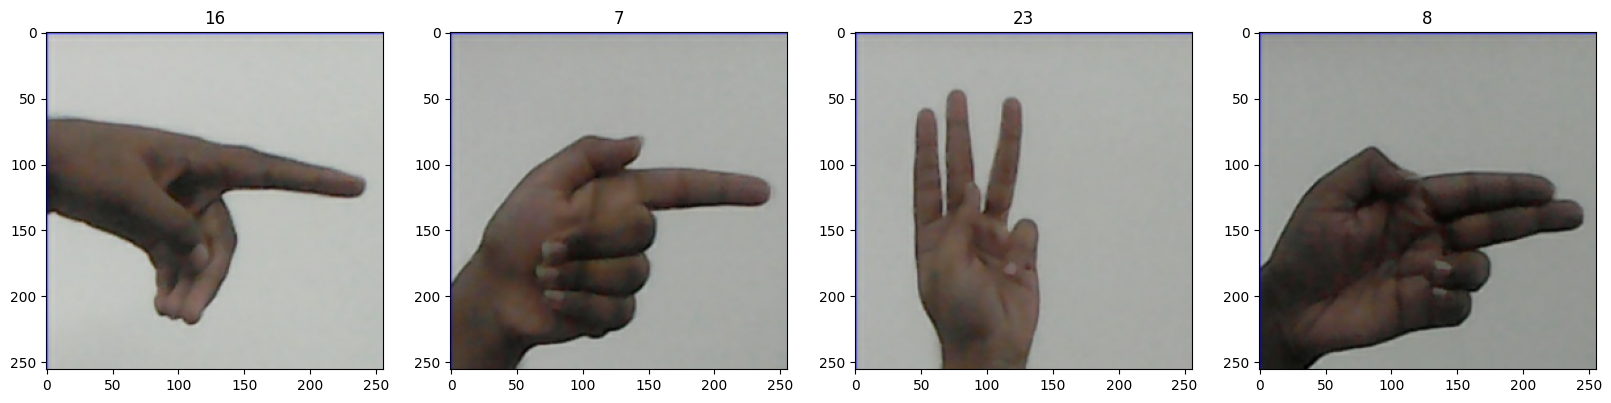

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
def scale(data):
  data_scaled = data.map(lambda x,y: (x/255, y))
  return data_scaled

In [ ]:
dataRAW = scale(dataRAW)
dataAT = scale(dataAT)
dataCE = scale(dataCE)


In [ ]:
dataFULL = dataRAW.concatenate(dataAT).concatenate(dataCE)

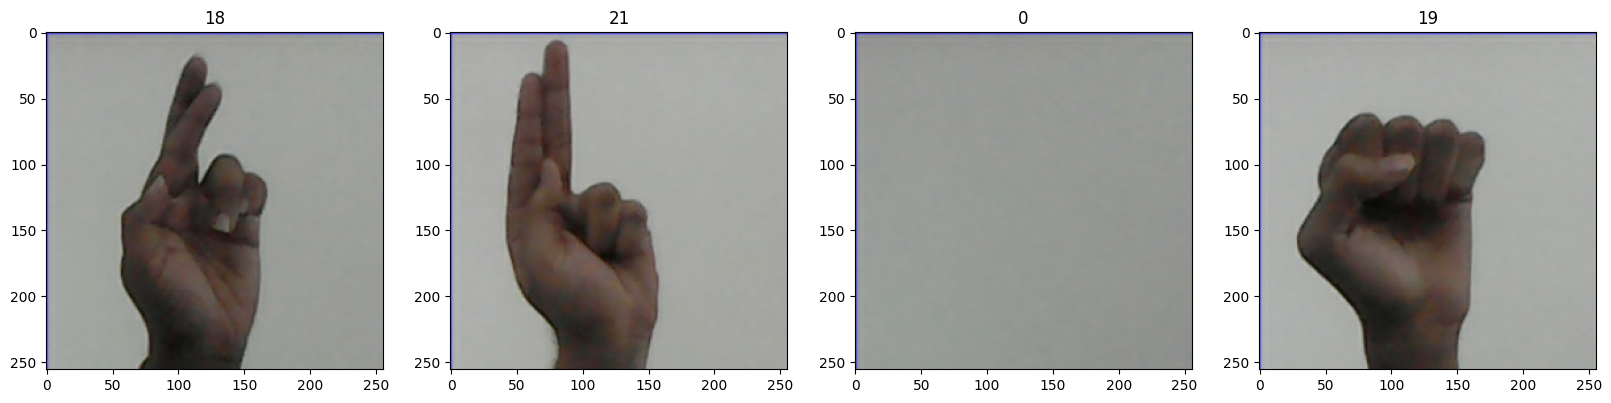

In [ ]:
batch = dataRAW.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [ ]:
def split_data(data):
  train_size = int(len(data)*.7)
  val_size = int(len(data)*.15)
  test_size = int(len(data)*.15)

  train = data.take(train_size)
  val = data.skip(train_size).take(val_size)
  test = data.skip(train_size+val_size).take(test_size)

  return train, val, test

In [ ]:
trainRAW, valRAW, testRAW = split_data(dataRAW)
trainAT, valAT, testAT = split_data(dataAT)
trainCE, valCE, testCE = split_data(dataCE)
trainFULL, valFULL, testFULL = split_data(dataFULL)

# 6. Build Deep Learning Model

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(27, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print input shape
print("Input Shape:", model.input_shape)

# Print output shape after each layer
for layer in model.layers:
    print("Layer Name:", layer.name)
    print("Output Shape:", layer.output_shape)

Input Shape: (None, 256, 256, 3)
Layer Name: conv2d
Output Shape: (None, 254, 254, 32)
Layer Name: max_pooling2d
Output Shape: (None, 127, 127, 32)
Layer Name: conv2d_1
Output Shape: (None, 125, 125, 16)
Layer Name: max_pooling2d_1
Output Shape: (None, 62, 62, 16)
Layer Name: conv2d_2
Output Shape: (None, 60, 60, 32)
Layer Name: max_pooling2d_2
Output Shape: (None, 30, 30, 32)
Layer Name: flatten
Output Shape: (None, 28800)
Layer Name: dense
Output Shape: (None, 256)
Layer Name: dense_1
Output Shape: (None, 27)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [ ]:
modelRAW = clone_model(model)
modelAT = clone_model(model)
modelCE = clone_model(model)
modelFULL = clone_model(model)

In [ ]:
modelRAW.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelAT.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelCE.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelFULL.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 7. Train

In [ ]:
# Use the ! shell command to run shell commands
!mkdir /content/logs

print("Directory created.")

logdir='logs'

Directory created.


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [ ]:
histRAW = modelRAW.fit(trainRAW, epochs=5, validation_data=valRAW, callbacks=[tensorboard_callback])

Epoch 1/5
177/177 [==============================] - 36s 129ms/step - loss: 1.1150 - accuracy: 0.6928 - val_loss: 0.1226 - val_accuracy: 0.9762
Epoch 2/5
177/177 [==============================] - 24s 135ms/step - loss: 0.0677 - accuracy: 0.9838 - val_loss: 0.0447 - val_accuracy: 0.9918
Epoch 3/5
177/177 [==============================] - 23s 125ms/step - loss: 0.0124 - accuracy: 0.9968 - val_loss: 0.0543 - val_accuracy: 0.9934
Epoch 4/5
177/177 [==============================] - 24s 134ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0483 - val_accuracy: 0.9951
Epoch 5/5
177/177 [==============================] - 24s 133ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0511 - val_accuracy: 0.9934


In [ ]:
histAT = modelAT.fit(trainAT, epochs=5, validation_data=valAT, callbacks=[tensorboard_callback])

Epoch 1/5
177/177 [==============================] - 23s 120ms/step - loss: 0.8334 - accuracy: 0.7768 - val_loss: 0.1054 - val_accuracy: 0.9720
Epoch 2/5
177/177 [==============================] - 21s 119ms/step - loss: 0.0310 - accuracy: 0.9922 - val_loss: 0.0974 - val_accuracy: 0.9836
Epoch 3/5
177/177 [==============================] - 23s 125ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0913 - val_accuracy: 0.9852
Epoch 4/5
177/177 [==============================] - 23s 129ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0843 - val_accuracy: 0.9885
Epoch 5/5
177/177 [==============================] - 20s 114ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.0591 - val_accuracy: 0.9918


In [ ]:
histCE = modelCE.fit(trainCE, epochs=5, validation_data=valCE, callbacks=[tensorboard_callback])

Epoch 1/5
177/177 [==============================] - 24s 122ms/step - loss: 0.3949 - accuracy: 0.8985 - val_loss: 0.0387 - val_accuracy: 0.9934
Epoch 2/5
177/177 [==============================] - 22s 125ms/step - loss: 0.0198 - accuracy: 0.9945 - val_loss: 0.0406 - val_accuracy: 0.9885
Epoch 3/5
177/177 [==============================] - 19s 107ms/step - loss: 0.0220 - accuracy: 0.9952 - val_loss: 0.0208 - val_accuracy: 0.9934
Epoch 4/5
177/177 [==============================] - 22s 123ms/step - loss: 0.0085 - accuracy: 0.9989 - val_loss: 0.0383 - val_accuracy: 0.9975
Epoch 5/5
177/177 [==============================] - 19s 106ms/step - loss: 1.8196e-04 - accuracy: 1.0000 - val_loss: 0.0453 - val_accuracy: 0.9967


In [ ]:
histFULL = modelFULL.fit(trainFULL, epochs=5, validation_data=valFULL, callbacks=[tensorboard_callback])

Epoch 1/5
533/533 [==============================] - 63s 113ms/step - loss: 0.5740 - accuracy: 0.8702 - val_loss: 0.2674 - val_accuracy: 0.9323
Epoch 2/5
533/533 [==============================] - 61s 114ms/step - loss: 0.0737 - accuracy: 0.9835 - val_loss: 0.1082 - val_accuracy: 0.9690
Epoch 3/5
533/533 [==============================] - 59s 111ms/step - loss: 0.0149 - accuracy: 0.9971 - val_loss: 0.1333 - val_accuracy: 0.9701
Epoch 4/5
533/533 [==============================] - 59s 111ms/step - loss: 0.0126 - accuracy: 0.9975 - val_loss: 0.2112 - val_accuracy: 0.9556
Epoch 5/5
533/533 [==============================] - 77s 145ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.0972 - val_accuracy: 0.9767


# 8. Plot Performance

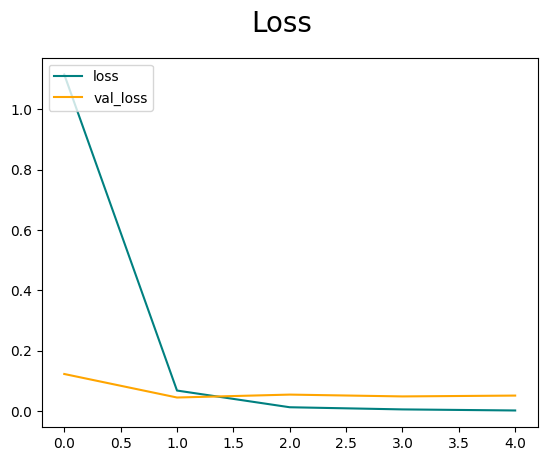

In [ ]:
fig = plt.figure()
plt.plot(histRAW.history['loss'], color='teal', label='loss')
plt.plot(histRAW.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

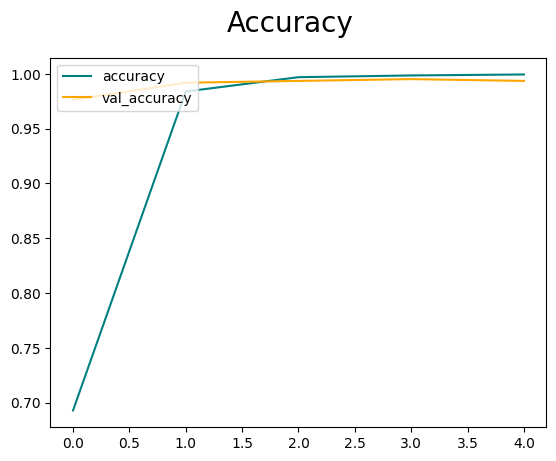

In [ ]:
fig = plt.figure()
plt.plot(histRAW.history['accuracy'], color='teal', label='accuracy')
plt.plot(histRAW.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [ ]:
def evaluate_test(model,modelName, test, testName):

  print(f"Model: {modelName} / Test: {testName}")
  print()

  # Initialize lists to store true and predicted labels
  true_labels = []
  predicted_labels = []

  # Loop through the test data to get true and predicted labels
  for batch in test.as_numpy_iterator():
      X, y = batch
      predicted_data = model.predict(X)
      yhat_classes = np.argmax(predicted_data, axis=1)

      true_labels.extend(y)
      predicted_labels.extend(yhat_classes)

  # Convert the lists to numpy arrays
  true_labels = np.array(true_labels)
  predicted_labels = np.array(predicted_labels)

  # Calculate precision, recall, and accuracy
  precision = precision_score(true_labels, predicted_labels, average='weighted')
  recall = recall_score(true_labels, predicted_labels, average='weighted')
  accuracy = accuracy_score(true_labels, predicted_labels)

  # Print precision, recall, and accuracy
  print(f"Precision: {precision * 100:.2f}%")
  print(f"Recall: {recall * 100:.2f}%")
  print(f"Accuracy: {accuracy * 100:.2f}%")

  # Calculate and print confusion matrix
  class_mapping = {
      0: 'None',
      1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G',
      8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M',
      14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S',
      20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'
  }

  # Map true and predicted labels using the class_mapping dictionary
  true_labels_mapped = [class_mapping[label] for label in true_labels]
  predicted_labels_mapped = [class_mapping[label] for label in predicted_labels]

  conf_matrix = confusion_matrix(true_labels_mapped, predicted_labels_mapped)
  class_names_mapped = [class_mapping[i] for i in range(27)]
  fig = go.Figure(data=[go.Heatmap(z=conf_matrix, x=class_names_mapped, y=class_names_mapped)])
  fig.update_layout(
      title=f"Confusion Matrix {modelName} applied on {testName}",
      xaxis_title="Predicted",
      yaxis_title="True",
      autosize=False,
      width=600,
      height=600
  )
  fig.show()


  # Print classification report with precision, recall, f1-score, and support
  class_report = classification_report(true_labels_mapped, predicted_labels_mapped)
  print()
  print(f"Classification Report for {modelName} applied on {testName}:")
  print(class_report)

  # Print summary
  print()
  test_loss, test_accuracy = model.evaluate(test)
  print(f"Test Loss for {modelName} applied on {testName}: {(test_loss * 100):.2f}%")
  print(f"Test Accuracy for {modelName} applied on {testName}: {(test_accuracy * 100):.2f}%")
  print("-----------------------------------------------------------------------")
  print()


In [ ]:
evaluate_test(modelRAW,"modelRAW", testRAW, "testRAW")
evaluate_test(modelRAW,"modelRAW", testAT, "testAT")
evaluate_test(modelRAW,"modelRAW", testCE, "testCE")

Model: modelRAW / Test: testRAW

1/1 [==============================] - 0s 31ms/step
Precision: 99.52%
Recall: 99.51%
Accuracy: 99.51%



Classification Report for modelRAW applied on testRAW:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        38
           B       1.00      1.00      1.00        51
           C       1.00      1.00      1.00        45
           D       1.00      0.97      0.99        37
           E       1.00      1.00      1.00        50
           F       1.00      1.00      1.00        44
           G       0.98      1.00      0.99        46
           H       1.00      1.00      1.00        50
           I       1.00      1.00      1.00        45
           J       1.00      0.97      0.99        40
           K       1.00      1.00      1.00        42
           L       1.00      1.00      1.00        50
           M       0.95      1.00      0.97        53
           N       0.97      0.93      0.95        40
        None       1.00      1.00      1.00        52
           O       1.00      1.00      1.00        48
           P       1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report for modelRAW applied on testAT:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        40
           B       0.00      0.00      0.00        44
           C       0.83      0.86      0.85        35
           D       1.00      0.56      0.72        41
           E       0.00      0.00      0.00        34
           F       0.00      0.00      0.00        47
           G       0.78      0.72      0.75        43
           H       0.88      0.88      0.88        43
           I       1.00      0.09      0.17        53
           J       0.53      0.15      0.23        55
           K       0.62      0.70      0.66        43
           L       1.00      0.62      0.77        50
           M       0.69      0.19      0.30        48
           N       0.00      0.00      0.00        46
        None       1.00      1.00      1.00        51
           O       0.47      0.53      0.50        47
           P       0.82   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



38/38 [==============================] - 9s 41ms/step - loss: 21.1077 - accuracy: 0.4844
Test Loss for modelRAW applied on testAT: 2110.77%
Test Accuracy for modelRAW applied on testAT: 48.44%
-----------------------------------------------------------------------

Model: modelRAW / Test: testCE

1/1 [==============================] - 0s 42ms/step
Precision: 61.34%
Recall: 42.19%
Accuracy: 42.19%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report for modelRAW applied on testCE:
              precision    recall  f1-score   support

           A       1.00      0.40      0.57        55
           B       0.12      0.03      0.04        38
           C       0.25      1.00      0.39        45
           D       0.84      0.78      0.81        40
           E       0.75      0.05      0.10        58
           F       1.00      0.07      0.13        44
           G       0.42      0.84      0.56        37
           H       0.83      0.67      0.74        52
           I       0.67      0.40      0.50        50
           J       0.00      0.00      0.00        40
           K       1.00      0.12      0.22        40
           L       1.00      0.04      0.07        57
           M       0.00      0.00      0.00        40
           N       0.00      0.00      0.00        54
        None       0.00      0.00      0.00        41
           O       1.00      0.38      0.55        40
           P       0.41   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



38/38 [==============================] - 9s 38ms/step - loss: 16.2056 - accuracy: 0.4252
Test Loss for modelRAW applied on testCE: 1620.56%
Test Accuracy for modelRAW applied on testCE: 42.52%
-----------------------------------------------------------------------



In [ ]:
evaluate_test(modelAT,"modelAT", testRAW, "testRAW")
evaluate_test(modelAT,"modelAT", testAT, "testAT")
evaluate_test(modelAT,"modelAT", testCE, "testCE")

Model: modelAT / Test: testRAW

1/1 [==============================] - 0s 43ms/step
Precision: 73.28%
Recall: 67.19%
Accuracy: 67.19%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report for modelAT applied on testRAW:
              precision    recall  f1-score   support

           A       1.00      0.03      0.05        40
           B       0.82      0.51      0.63        55
           C       1.00      0.75      0.86        48
           D       0.30      0.59      0.40        34
           E       0.83      0.56      0.67        52
           F       0.86      0.72      0.78        43
           G       0.47      1.00      0.64        46
           H       0.97      0.91      0.94        43
           I       0.93      0.32      0.47        44
           J       0.90      0.60      0.72        43
           K       0.96      0.61      0.75        41
           L       0.80      0.79      0.80        47
           M       0.48      0.39      0.43        54
           N       0.60      0.47      0.52        45
        None       0.74      1.00      0.85        51
           O       0.49      0.74      0.59        46
           P       1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



38/38 [==============================] - 11s 43ms/step - loss: 1.7421 - accuracy: 0.6842
Test Loss for modelAT applied on testRAW: 174.21%
Test Accuracy for modelAT applied on testRAW: 68.42%
-----------------------------------------------------------------------

Model: modelAT / Test: testAT

1/1 [==============================] - 0s 44ms/step
Precision: 99.68%
Recall: 99.67%
Accuracy: 99.67%



Classification Report for modelAT applied on testAT:
              precision    recall  f1-score   support

           A       0.97      1.00      0.99        36
           B       1.00      1.00      1.00        48
           C       1.00      1.00      1.00        34
           D       1.00      1.00      1.00        39
           E       1.00      1.00      1.00        35
           F       1.00      1.00      1.00        47
           G       1.00      1.00      1.00        44
           H       1.00      1.00      1.00        40
           I       1.00      0.98      0.99        51
           J       1.00      1.00      1.00        51
           K       1.00      1.00      1.00        43
           L       1.00      1.00      1.00        49
           M       1.00      1.00      1.00        47
           N       0.98      1.00      0.99        49
        None       1.00      1.00      1.00        54
           O       1.00      1.00      1.00        45
           P       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report for modelAT applied on testCE:
              precision    recall  f1-score   support

           A       1.00      0.02      0.04        54
           B       0.00      0.00      0.00        36
           C       1.00      0.82      0.90        49
           D       0.00      0.00      0.00        41
           E       0.00      0.00      0.00        58
           F       0.00      0.00      0.00        46
           G       1.00      0.27      0.43        33
           H       0.00      0.00      0.00        49
           I       0.00      0.00      0.00        41
           J       0.00      0.00      0.00        40
           K       0.00      0.00      0.00        42
           L       0.00      0.00      0.00        53
           M       0.00      0.00      0.00        41
           N       0.00      0.00      0.00        53
        None       0.00      0.00      0.00        45
           O       0.00      0.00      0.00        44
           P       0.04    

In [ ]:
evaluate_test(modelCE,"modelCE", testRAW, "testRAW")
evaluate_test(modelCE,"modelCE", testAT, "testAT")
evaluate_test(modelCE,"modelCE", testCE,"testCE")

Model: modelCE / Test: testRAW

1/1 [==============================] - 0s 52ms/step
Precision: 1.92%
Recall: 4.28%
Accuracy: 4.28%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report for modelCE applied on testRAW:
              precision    recall  f1-score   support

           A       0.04      1.00      0.08        42
           B       0.00      0.00      0.00        55
           C       0.44      0.17      0.25        46
           D       0.00      0.00      0.00        38
           E       0.00      0.00      0.00        52
           F       0.00      0.00      0.00        44
           G       0.00      0.00      0.00        47
           H       0.00      0.00      0.00        50
           I       0.00      0.00      0.00        49
           J       0.00      0.00      0.00        39
           K       0.00      0.00      0.00        41
           L       0.00      0.00      0.00        43
           M       0.00      0.00      0.00        57
           N       0.00      0.00      0.00        42
        None       0.00      0.00      0.00        55
           O       0.00      0.00      0.00        46
           P       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



38/38 [==============================] - 10s 43ms/step - loss: 31.3406 - accuracy: 0.0395
Test Loss for modelCE applied on testRAW: 3134.06%
Test Accuracy for modelCE applied on testRAW: 3.95%
-----------------------------------------------------------------------

Model: modelCE / Test: testAT

1/1 [==============================] - 0s 49ms/step
Precision: 8.23%
Recall: 14.97%
Accuracy: 14.97%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report for modelCE applied on testAT:
              precision    recall  f1-score   support

           A       0.25      0.75      0.38        40
           B       0.06      1.00      0.11        46
           C       0.92      0.85      0.88        40
           D       0.00      0.00      0.00        38
           E       0.00      0.00      0.00        31
           F       0.00      0.00      0.00        49
           G       1.00      0.55      0.71        40
           H       0.00      0.00      0.00        42
           I       0.00      0.00      0.00        55
           J       0.00      0.00      0.00        56
           K       0.00      0.00      0.00        41
           L       0.00      0.00      0.00        46
           M       0.00      0.00      0.00        47
           N       0.00      0.00      0.00        50
        None       0.00      0.00      0.00        51
           O       0.00      0.00      0.00        44
           P       0.00    


Classification Report for modelCE applied on testCE:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        53
           B       1.00      1.00      1.00        36
           C       0.98      1.00      0.99        44
           D       1.00      1.00      1.00        36
           E       1.00      0.98      0.99        59
           F       1.00      1.00      1.00        45
           G       0.97      1.00      0.99        34
           H       1.00      0.98      0.99        52
           I       1.00      1.00      1.00        41
           J       1.00      1.00      1.00        48
           K       1.00      1.00      1.00        43
           L       1.00      1.00      1.00        53
           M       1.00      1.00      1.00        44
           N       1.00      1.00      1.00        51
        None       1.00      1.00      1.00        43
           O       1.00      1.00      1.00        41
           P       1.00    

In [ ]:
evaluate_test(modelFULL,"modelFULL", testRAW, "testRAW")
evaluate_test(modelFULL,"modelFULL", testAT, "testAT")
evaluate_test(modelFULL,"modelFULL", testCE, "testCE")
evaluate_test(modelFULL,"modelFULL", testFULL, "testFULL")

Model: modelFULL / Test: testRAW

1/1 [==============================] - 0s 34ms/step
Precision: 99.59%
Recall: 99.59%
Accuracy: 99.59%



Classification Report for modelFULL applied on testRAW:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        40
           B       1.00      0.98      0.99        54
           C       1.00      1.00      1.00        48
           D       0.97      0.97      0.97        35
           E       0.98      1.00      0.99        54
           F       0.98      1.00      0.99        42
           G       1.00      1.00      1.00        45
           H       1.00      1.00      1.00        50
           I       1.00      1.00      1.00        46
           J       1.00      1.00      1.00        39
           K       0.98      0.98      0.98        42
           L       1.00      1.00      1.00        48
           M       1.00      1.00      1.00        56
           N       1.00      1.00      1.00        41
        None       1.00      1.00      1.00        52
           O       1.00      1.00      1.00        52
           P       1.00 


Classification Report for modelFULL applied on testAT:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        34
           B       1.00      1.00      1.00        45
           C       1.00      1.00      1.00        38
           D       1.00      1.00      1.00        40
           E       1.00      1.00      1.00        32
           F       1.00      1.00      1.00        50
           G       1.00      1.00      1.00        41
           H       1.00      1.00      1.00        45
           I       1.00      1.00      1.00        55
           J       1.00      1.00      1.00        56
           K       1.00      1.00      1.00        45
           L       1.00      1.00      1.00        53
           M       1.00      1.00      1.00        52
           N       1.00      1.00      1.00        46
        None       1.00      1.00      1.00        53
           O       1.00      1.00      1.00        46
           P       1.00  


Classification Report for modelFULL applied on testCE:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        53
           B       0.92      0.97      0.94        35
           C       0.98      1.00      0.99        46
           D       0.98      1.00      0.99        40
           E       0.98      0.98      0.98        57
           F       0.98      1.00      0.99        44
           G       0.97      0.97      0.97        37
           H       1.00      0.98      0.99        51
           I       0.98      1.00      0.99        48
           J       1.00      1.00      1.00        46
           K       0.93      0.98      0.96        44
           L       1.00      1.00      1.00        56
           M       0.95      0.98      0.97        43
           N       1.00      0.96      0.98        51
        None       1.00      1.00      1.00        43
           O       0.95      1.00      0.97        38
           P       0.98  


Classification Report for modelFULL applied on testFULL:
              precision    recall  f1-score   support

           A       1.00      0.98      0.99       151
           B       0.92      0.98      0.95       127
           C       0.99      1.00      1.00       132
           D       0.97      1.00      0.98       121
           E       0.99      0.97      0.98       141
           F       0.98      0.98      0.98       131
           G       0.98      0.99      0.98       131
           H       1.00      0.99      0.99       137
           I       0.99      0.99      0.99       134
           J       0.98      1.00      0.99       135
           K       0.94      0.96      0.95       134
           L       1.00      1.00      1.00       147
           M       0.97      0.98      0.97       127
           N       0.98      0.97      0.98       131
        None       1.00      1.00      1.00       142
           O       0.98      0.99      0.98       130
           P       0.99

# Test with another dataset

In [ ]:
# Step 1: Set up Kaggle API credentials
kaggle_credentials_path = "/content/kaggle.json"
if os.path.exists(kaggle_credentials_path):
    kaggle_directory = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_directory, exist_ok=True)
    kaggle_config_path = os.path.join(kaggle_directory, "kaggle.json")
    shutil.copy(kaggle_credentials_path, kaggle_config_path)
    os.chmod(kaggle_config_path, 0o600)
    # Step 2: Download dataset
    dataset_name = "lexset/synthetic-asl-alphabet"
    download_command = f"kaggle datasets download -d {dataset_name}"
    os.system(download_command)
    # Step 3: Unzip dataset and remove ZIP files
    zip_files = [file for file in os.listdir() if file.endswith(".zip")]
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall()
        os.remove(zip_file)
    print("Dataset download and setup completed.")
else:
    print("Kaggle API credentials (kaggle.json) not found.")


Dataset download and setup completed.


Found 2700 files belonging to 27 classes.


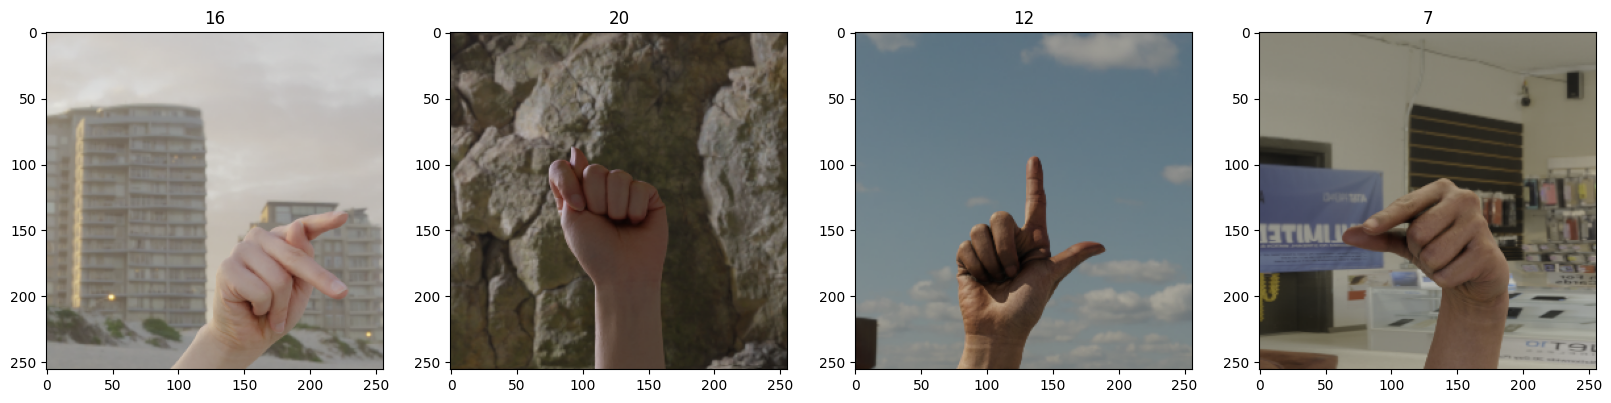

In [ ]:
dataExternalData = tf.keras.utils.image_dataset_from_directory("/content/Test_Alphabet")
dataExternalData_iterator = dataExternalData.as_numpy_iterator()
batchExternalData = dataExternalData_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batchExternalData[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batchExternalData[1][idx])

dataExternalData = dataExternalData.map(lambda x, y: (x / 255, y))

In [ ]:
test_loss_external_data, test_accuracy_external_data = modelFULL.evaluate(dataExternalData)
print("Test Loss for dataExternalData: {:.2f}".format(test_loss_external_data))
print("Test Accuracy for dataExternalData: {:.2f}%".format(test_accuracy_external_data * 100))

85/85 [==============================] - 25s 270ms/step - loss: 7.2456 - accuracy: 0.0315
Test Loss for dataExternalData: 7.25
Test Accuracy for dataExternalData: 3.15%
